In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

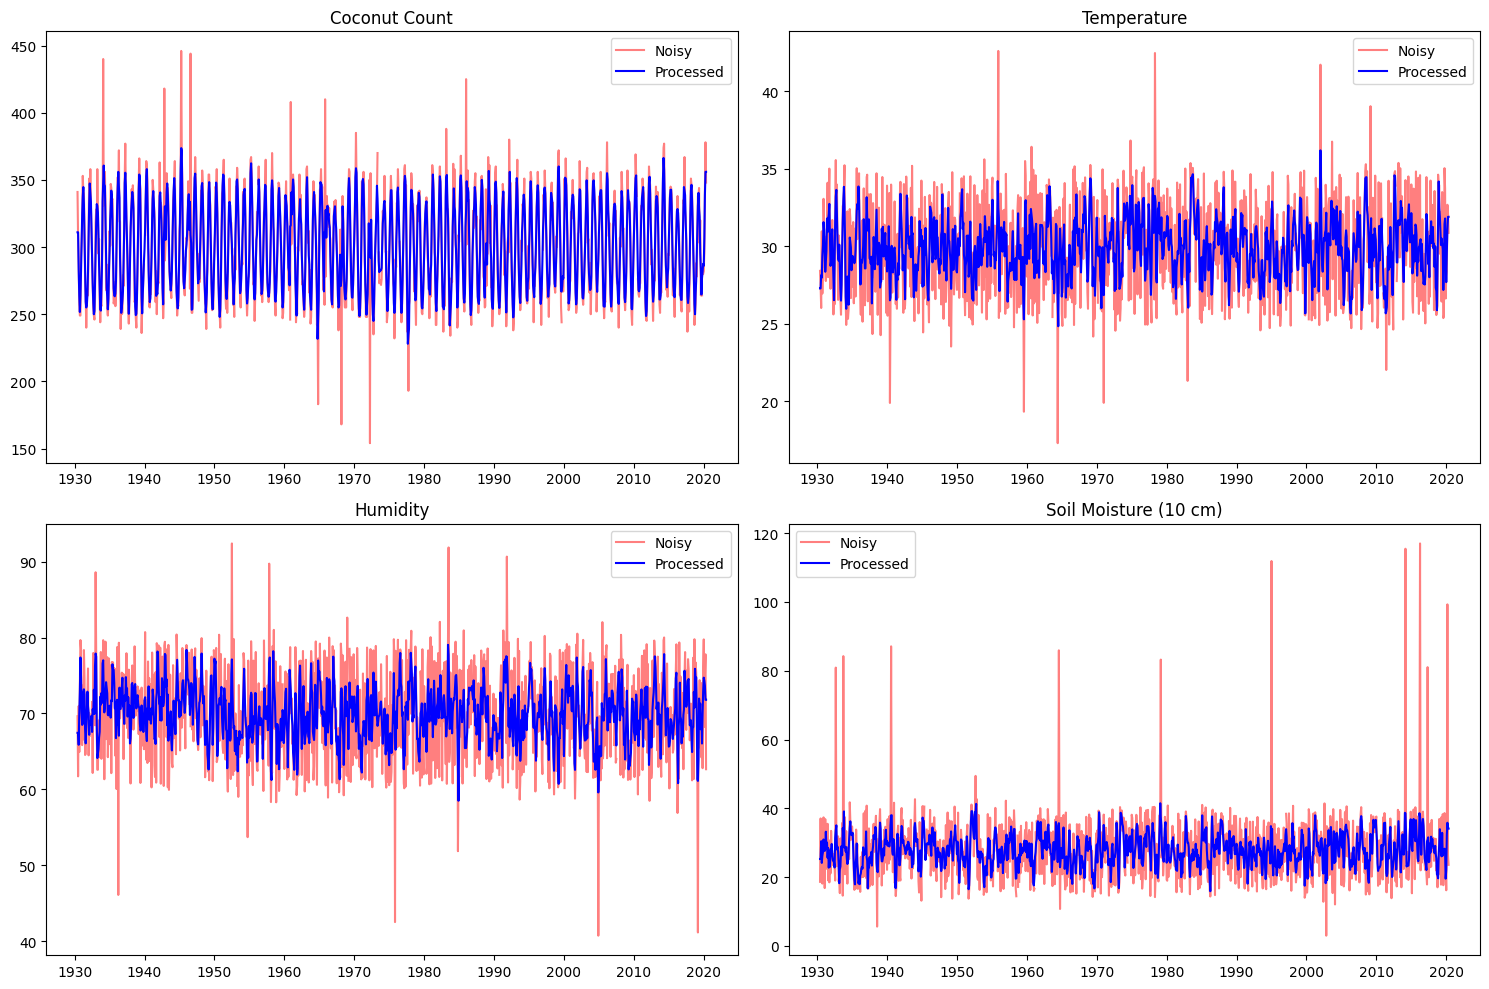


Summary Statistics - Before Preprocessing:
                      Date  Soil Moisture (10 cm) (%)  \
count                 1080                1070.000000   
mean   1975-05-16 09:24:00                  28.220823   
min    1930-05-31 00:00:00                   2.959643   
25%    1952-11-22 12:00:00                  21.175535   
50%    1975-05-15 12:00:00                  27.841409   
75%    1997-11-07 12:00:00                  33.795618   
max    2020-04-30 00:00:00                 117.012228   
std                    NaN                   9.855447   

       Soil Moisture (20 cm) (%)  Soil Moisture (30 cm) (%)  \
count                1070.000000                1070.000000   
mean                   35.615576                  43.048099   
min                     5.493161                   3.469419   
25%                    26.987729                  34.502093   
50%                    34.627988                  43.457730   
75%                    43.087884                  51.542462   
m

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
import matplotlib.pyplot as plt

# Load raw data
df_noisy = pd.read_csv('raw_data_coconut_data.csv', parse_dates=['Date'])

# Preprocessing function
def preprocess_data(df):
   df_processed = df.copy()
   
   # Handle missing values
   numeric_columns = df.select_dtypes(include=[np.number]).columns
   for col in numeric_columns:
       df_processed[col] = df_processed[col].fillna(df_processed[col].median())
   
   # Remove outliers using IQR method
   for col in numeric_columns:
       if col != 'Rain Status (0/1)':  
           Q1 = df_processed[col].quantile(0.25)
           Q3 = df_processed[col].quantile(0.75)
           IQR = Q3 - Q1
           lower_bound = Q1 - 1.5 * IQR
           upper_bound = Q3 + 1.5 * IQR
           df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
   
   # Ensure values are within realistic ranges
   df_processed['Soil Moisture (10 cm) (%)'] = df_processed['Soil Moisture (10 cm) (%)'].clip(0, 100)
   df_processed['Soil Moisture (20 cm) (%)'] = df_processed['Soil Moisture (20 cm) (%)'].clip(0, 100)
   df_processed['Soil Moisture (30 cm) (%)'] = df_processed['Soil Moisture (30 cm) (%)'].clip(0, 100)
   df_processed['Temperature (°C)'] = df_processed['Temperature (°C)'].clip(20, 40)
   df_processed['Humidity (%)'] = df_processed['Humidity (%)'].clip(0, 100)
   df_processed['Rainfall (mm)'] = df_processed['Rainfall (mm)'].clip(0, None)
   df_processed['Coconut Count'] = df_processed['Coconut Count'].clip(200, 400)
   
   # Apply smoothing using rolling mean
   window_size = 3
   for col in numeric_columns:
       if col not in ['Rain Status (0/1)', 'Plant Age (years)']:
           df_processed[col] = df_processed[col].rolling(window=window_size, center=True).mean()
   
   # Fill NaN values created by rolling mean
   df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
   
   return df_processed

# Apply preprocessing
df_processed = preprocess_data(df_noisy)

# Create visualization of before and after preprocessing
plt.figure(figsize=(15, 10))

# Plot for Coconut Count
plt.subplot(2, 2, 1)
plt.plot(df_noisy['Date'], df_noisy['Coconut Count'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Coconut Count'], 'b-', label='Processed')
plt.title('Coconut Count')
plt.legend()

# Plot for Temperature
plt.subplot(2, 2, 2)
plt.plot(df_noisy['Date'], df_noisy['Temperature (°C)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Temperature (°C)'], 'b-', label='Processed')
plt.title('Temperature')
plt.legend()

# Plot for Humidity
plt.subplot(2, 2, 3)
plt.plot(df_noisy['Date'], df_noisy['Humidity (%)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Humidity (%)'], 'b-', label='Processed')
plt.title('Humidity')
plt.legend()

# Plot for Soil Moisture
plt.subplot(2, 2, 4)
plt.plot(df_noisy['Date'], df_noisy['Soil Moisture (10 cm) (%)'], 'r-', alpha=0.5, label='Noisy')
plt.plot(df_processed['Date'], df_processed['Soil Moisture (10 cm) (%)'], 'b-', label='Processed')
plt.title('Soil Moisture (10 cm)')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics - Before Preprocessing:")
print(df_noisy.describe())
print("\nSummary Statistics - After Preprocessing:")
print(df_processed.describe())

# Print missing values information
print("\nMissing Values - Before Preprocessing:")
print(df_noisy.isnull().sum())
print("\nMissing Values - After Preprocessing:")
print(df_processed.isnull().sum())

# Save processed data
df_processed.to_csv('processed_coconut_data.csv', index=False)
print("\nProcessed data saved to 'processed_coconut_data.csv'")

In [ ]:
# Load the dataset
df = pd.read_csv('processed_coconut_data.csv', parse_dates=['Date'], index_col='Date')
df_before = pd.read_csv('raw_data_coconut_data.csv', parse_dates=['Date'],  index_col='Date')

In [19]:
df.head(2)


,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Soil Type,Soil Type (Numeric),Coconut Count
Date,,,,,,,,,,,
1930-05-31,25.247752,31.329343,41.908014,5,27.276334,67.448574,5.012583,1,Red Yellow Podzolic,4.0,311.0
1930-06-30,25.247752,31.329343,41.908014,4,27.276334,67.448574,5.012583,1,Red Yellow Podzolic,4.0,311.0


In [20]:
df_before.head(2)

,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Soil Type,Soil Type (Numeric),Coconut Count
Date,,,,,,,,,,,
1930-05-31,18.612376,21.928536,24.022264,5,28.409730,69.641348,11.590492,1,Red Yellow Podzolic,4,341.0
1930-06-30,37.046367,37.597259,42.372253,4,27.407402,61.713900,7.587827,1,Red Yellow Podzolic,4,306.0


In [21]:
train_size = int(len(df) * 0.8)
train = df['Coconut Count'][:train_size]
test = df['Coconut Count'][train_size:]

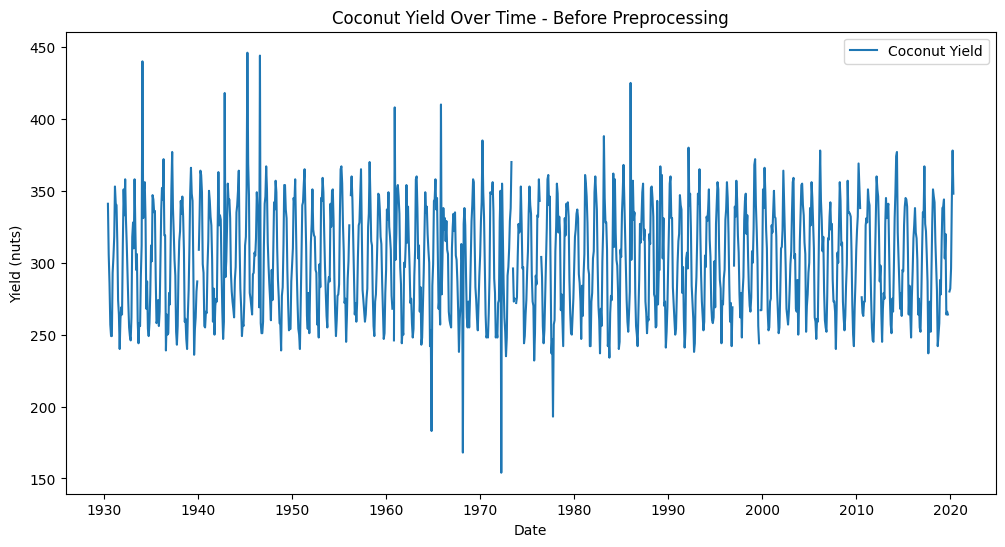

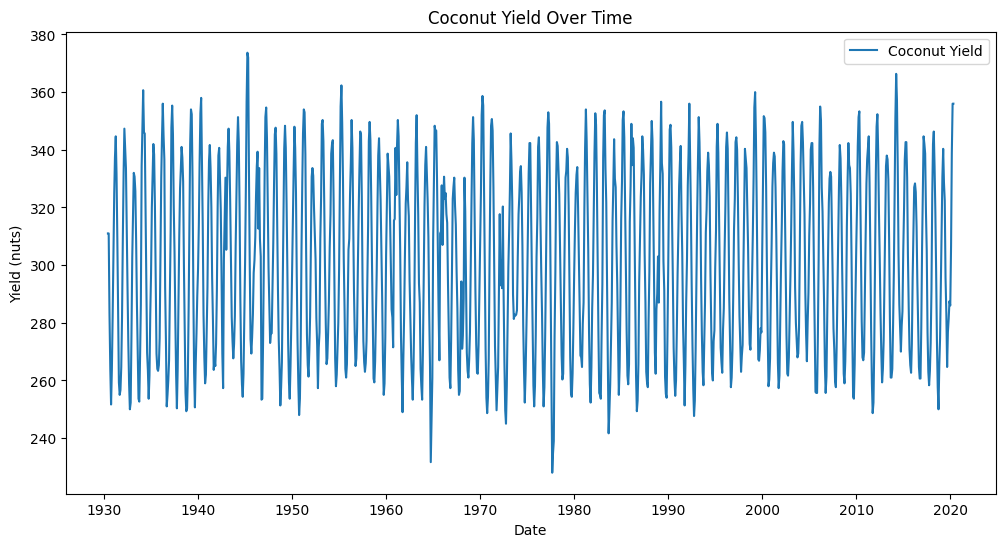

In [22]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_before['Coconut Count'], label='Coconut Yield')
plt.title('Coconut Yield Over Time - Before Preprocessing')
plt.xlabel('Date')
plt.ylabel('Yield (nuts)')
plt.legend()
plt.show()

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Coconut Count'], label='Coconut Yield')
plt.title('Coconut Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield (nuts)')
plt.legend()
plt.show()

In [23]:
# Test for stationarity (ADF test)
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('result', result)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

In [24]:
test_stationarity(df['Coconut Count'])

result (-6.033145646074728, 1.402327735501696e-07, 21, 1058, {'1%': -3.4365458759424543, '5%': -2.8642756688664193, '10%': -2.5682265737329413}, 6894.133952237799)
ADF Statistic: -6.033145646074728
p-value: 1.402327735501696e-07


In [25]:
def train_evaluate_model(model_name, train, test):
    if model_name == 'ARIMA':
        auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
        model = ARIMA(train, order=auto_model.order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
        
    elif model_name == 'Holt-Winters':
        model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
        fitted = model.fit()
        forecast = fitted.forecast(len(test))
        fitted_model = fitted
        
    elif model_name == 'SARIMA':
        model = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    accuracy = 100 * (1 - rmse/np.mean(test))
    
    return fitted_model, forecast, {'MAE': mae, 'RMSE': rmse, 'Accuracy': accuracy}

In [26]:
models = ['ARIMA', 'Holt-Winters', 'SARIMA']
results = {}
best_accuracy = -np.inf
best_model = None

for model_name in models:
    model, forecast, metrics = train_evaluate_model(model_name, train, test)
    results[model_name] = {'model': model, 'forecast': forecast, 'metrics': metrics}
    
    if metrics['Accuracy'] > best_accuracy:
        best_accuracy = metrics['Accuracy']
        best_model = model_name

c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 


ARIMA:
Testing Accuracy: 97.26%

Holt-Winters:
Testing Accuracy: 97.32%

SARIMA:
Testing Accuracy: 97.24%


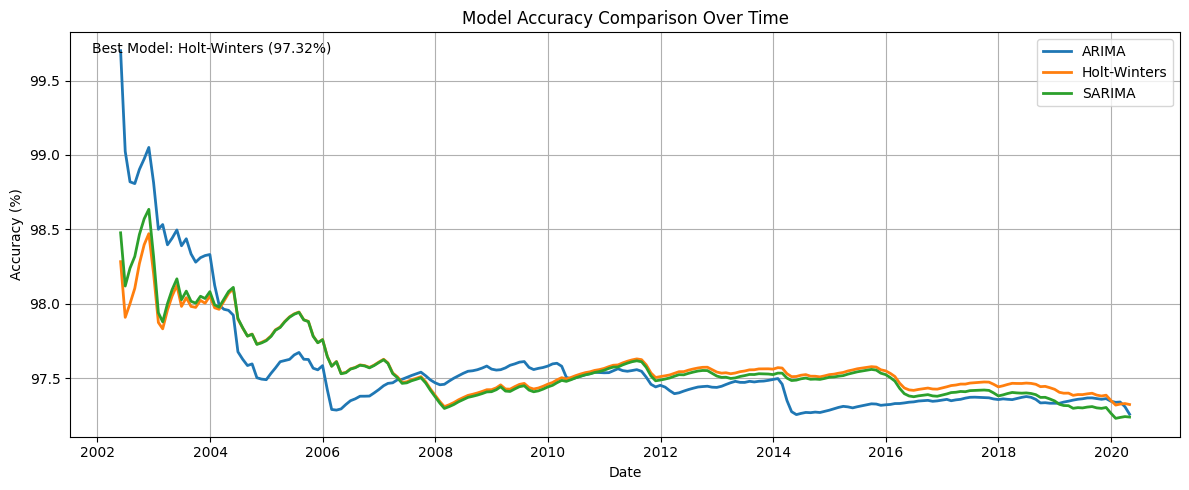


Best Model: Holt-Winters (97.32%)


In [27]:
def calculate_and_plot_accuracies(models, train, test):
    plt.figure(figsize=(12, 5))
    model_accuracies = {}
    
    for model_name, result in results.items():
        forecast = result['forecast']
        
        # Calculate test accuracies over time (for the plot)
        test_accuracies = []
        for t in range(1, len(test) + 1):
            actual = test[:t]
            pred = forecast[:t]
            accuracy = 100 * (1 - np.sqrt(mean_squared_error(actual, pred)) / np.mean(actual))
            test_accuracies.append(accuracy)
        
        # Plot test accuracies over time
        plt.plot(test.index, test_accuracies, '-', linewidth=2, label=f'{model_name}')
        
        # Calculate final accuracies for the whole train and test sets
        final_test_accuracy = test_accuracies[-1]  # Last accuracy value
        train_pred = result.get('fitted_values', None)  # Get training predictions if available
        
        if train_pred is not None:
            train_accuracy = 100 * (1 - np.sqrt(mean_squared_error(train, train_pred)) / np.mean(train))
        else:
            train_accuracy = None
            
        model_accuracies[model_name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': final_test_accuracy
        }
        
        # Print accuracies for each model
        print(f"\n{model_name}:")
        if train_accuracy is not None:
            print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Testing Accuracy: {final_test_accuracy:.2f}%")
    
    # Plot formatting
    plt.title('Model Accuracy Comparison Over Time')
    plt.xlabel('Date')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Add annotation for best model
    plt.annotate(f'Best Model: {best_model} ({best_accuracy:.2f}%)',
                xy=(0.02, 0.95), xycoords='axes fraction')
    
    plt.tight_layout()
    plt.show()
    
    return model_accuracies

# Calculate accuracies and create plot
accuracies = calculate_and_plot_accuracies(models, train, test)

# Print best model summary
print(f"\nBest Model: {best_model} ({best_accuracy:.2f}%)")

In [28]:
import joblib

# Save the model to a file
joblib.dump(best_model, 'best_yield_predictor_for_seasonal_patterns.pkl')

['best_yield_predictor_for_seasonal_patterns.pkl']

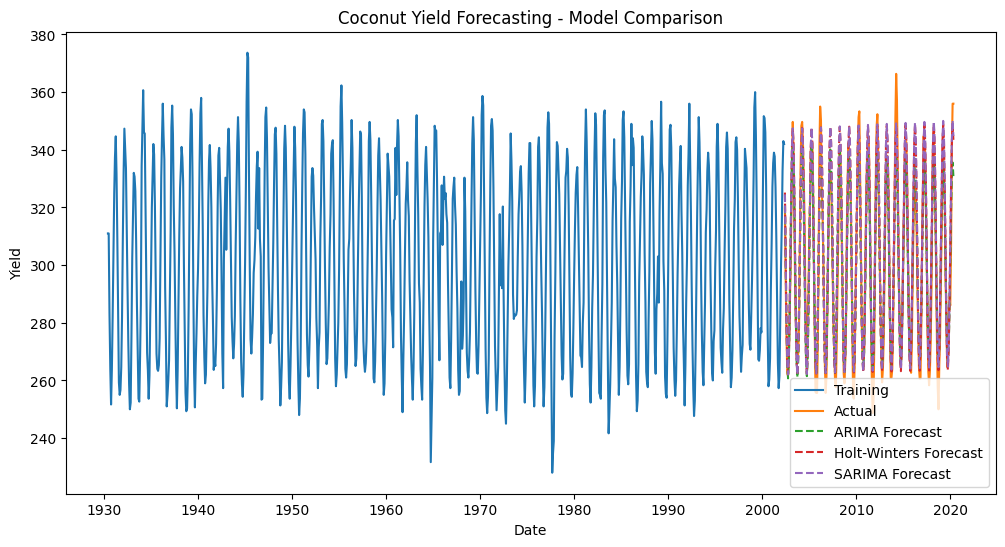

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
for model_name, result in results.items():
    plt.plot(test.index, result['forecast'], label=f'{model_name} Forecast', linestyle='--')
plt.title('Coconut Yield Forecasting - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [30]:
future_steps = 6
if best_model == 'ARIMA' or best_model == 'SARIMA':
    best_forecast = results[best_model]['model'].forecast(steps=future_steps)
elif best_model == 'Holt-Winters':
    best_forecast = results[best_model]['model'].forecast(future_steps)

future_dates = pd.date_range(start=test.index[-1], periods=future_steps+1, freq='M')[1:]
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Yield': best_forecast
})

print("\nNext 6 months predictions:")
print(forecast_df)


Next 6 months predictions:
                 Date  Predicted_Yield
2002-05-31 2020-05-31       325.156481
2002-06-30 2020-06-30       302.246391
2002-07-31 2020-07-31       280.463781
2002-08-31 2020-08-31       266.053002
2002-09-30 2020-09-30       262.179887
2002-10-31 2020-10-31       269.217309
